In [1]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import payments_manager as pm
import numpy as np

#pm.help()
pm.init(debug=True)
pm.info()
df_jo = pm.df('df_jo')
df_jo.info()
pm.info()



Lista de dataframes: ['cr', 'fe', 'cr_cp', 'fe_cp', 'df_jo', 'df_jall']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32094 non-null  int64          
 1   amount                      32094 non-null  float64        
 2   stat_cr                     32094 non-null  object         
 3   created_at                  32094 non-null  datetime64[ns] 
 4   user_id                     32094 non-null  int64          
 5   active                      32094 non-null  int64          
 6   moderated_at                21759 non-null  datetime64[ns] 
 7   reimbursement_date          32094 non-null  datetime64[ns] 
 8   cash_request_received_date  24149 non-null  datetime64[ns] 
 9   money_back_date             23917 non-null  datetime64[ns] 
 10  transfer_type               32094 

In [2]:
# Filtrar filas con estado de fees "accepted"
#df_jo = df_jo[df_jo['stat_fe'] == 'accepted']

# Filtrar filas con tipo de transferencia "regular" o "instant"
#df_jo = df_jo[df_jo['transfer_type'] == 'instant']

# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]



# Filtrar filas con estado de fees "accepted"
# df_jo = df_jo[df_jo['stat_fe'] == 'accepted']

# Filtrar filas con tipo de transferencia "regular" o "instant"
# df_jo = df_jo[df_jo['transfer_type'] == 'instant']

# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]

# Calcular métricas mensuales
monthly_data = df_jo.groupby('Mes_created_at').agg(
    total_fees=('fee', 'sum'),
    total_adelantos=(
        'id_cr', 
        lambda ids: df_jo.loc[ids.index]
            .drop_duplicates(subset='id_cr')
            .loc[df_jo.loc[ids.index, 'cash_request_received_date'].notna(), 'amount']
            .sum()
    )
).reset_index()

# Calcular el ratio de fees sobre adelantos
monthly_data['fees_ratio'] = monthly_data['total_fees'] / monthly_data['total_adelantos'] * 100

# Mostrar la evolución mensual
print(monthly_data)



   Mes_created_at  total_fees  total_adelantos  fees_ratio
0         2019-11         0.0              0.0         NaN
1         2019-12         0.0          16349.0    0.000000
2         2020-01         0.0          10579.0    0.000000
3         2020-02         0.0          10625.0    0.000000
4         2020-03         0.0          16200.0    0.000000
5         2020-04         5.0          31333.0    0.015958
6         2020-05      1285.0          57223.0    2.245601
7         2020-06      8725.0         153973.0    5.666578
8         2020-07     10395.0         184121.0    5.645744
9         2020-08     17565.0         178551.0    9.837525
10        2020-09     22935.0         224121.0   10.233311
11        2020-10     43815.0         459082.0    9.544047


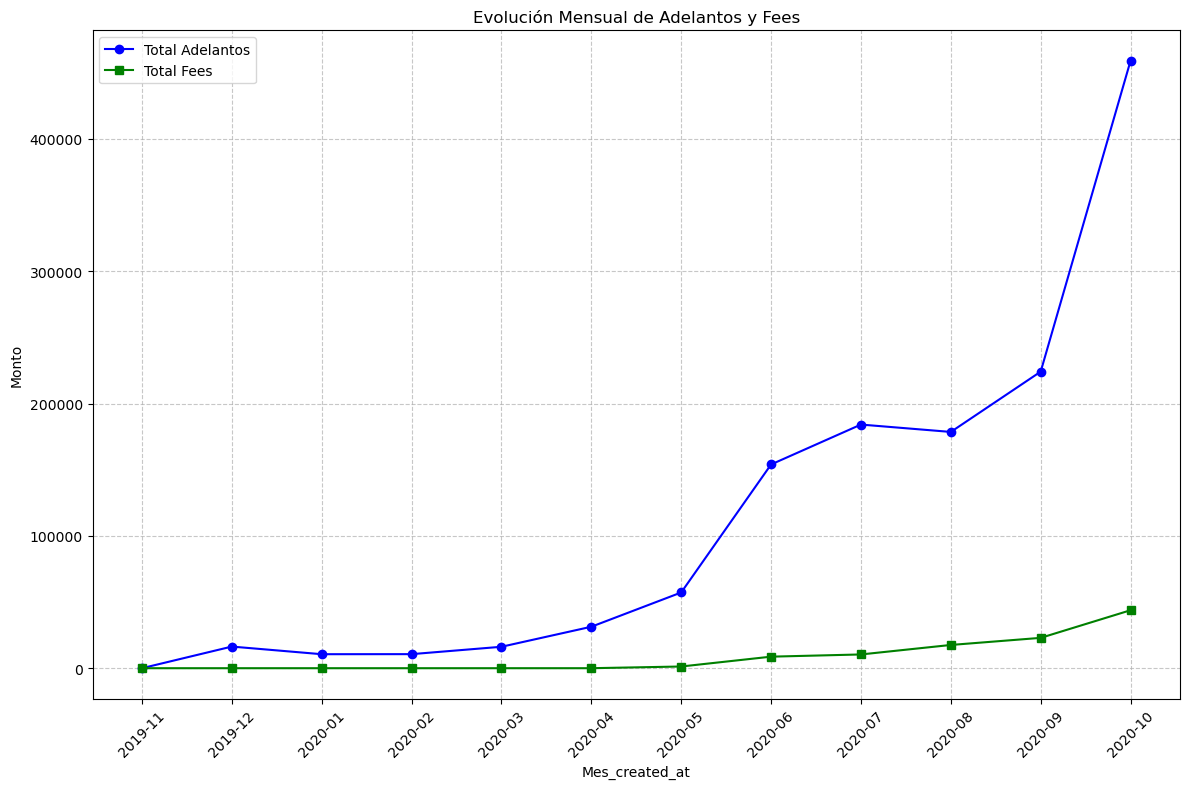

In [3]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar adelantos y fees en el mismo eje y
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_adelantos'], 
    marker='o', 
    label='Total Adelantos', 
    color='blue'
)
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees'], 
    marker='s', 
    label='Total Fees', 
    color='green'
)

# Configurar etiquetas y título
ax.set_xlabel('Mes_created_at')
ax.set_ylabel('Monto')
ax.set_title('Evolución Mensual de Adelantos y Fees')
ax.legend()  # Mostrar la leyenda para las líneas
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


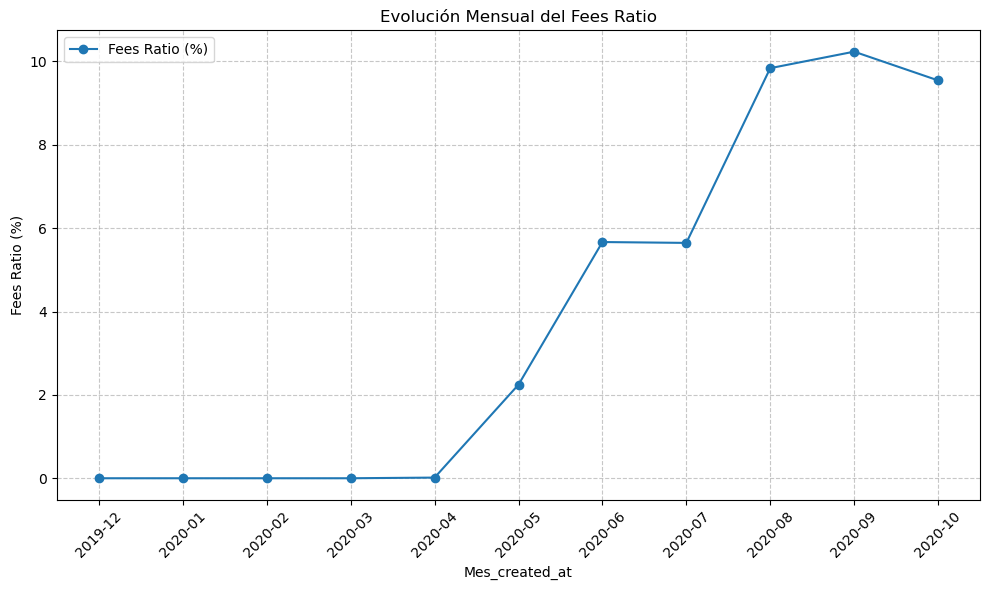

In [4]:
# Graficar la evolución del fees_ratio
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['Mes_created_at'].astype(str), monthly_data['fees_ratio'], marker='o', label='Fees Ratio (%)')
plt.title('Evolución Mensual del Fees Ratio')
plt.xlabel('Mes_created_at')
plt.ylabel('Fees Ratio (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Calcular las métricas mensuales segregadas por transfer_type
monthly_data = df_jo.groupby(['Mes_created_at', 'transfer_type']).agg(
    total_fees=('fee', 'sum'),
    total_adelantos=('amount', 'sum')
).reset_index()

# Calcular el ratio de fees sobre adelantos
monthly_data['fees_ratio'] = monthly_data['total_fees'] / monthly_data['total_adelantos'] * 100

monthly_data

,Mes_created_at,transfer_type,total_fees,total_adelantos,fees_ratio
0,2019-11,regular,0.0,1.0,0.000000
1,2019-12,regular,0.0,27297.0,0.000000
2,2020-01,regular,0.0,21587.0,0.000000
3,2020-02,regular,0.0,16653.0,0.000000
4,2020-03,regular,0.0,23549.0,0.000000
5,2020-04,regular,5.0,46093.0,0.010848
6,2020-05,regular,1285.0,94406.0,1.361142
7,2020-06,regular,8725.0,344186.0,2.534967
8,2020-07,instant,1390.0,40669.0,3.417837
9,2020-07,regular,9005.0,395428.0,2.277279


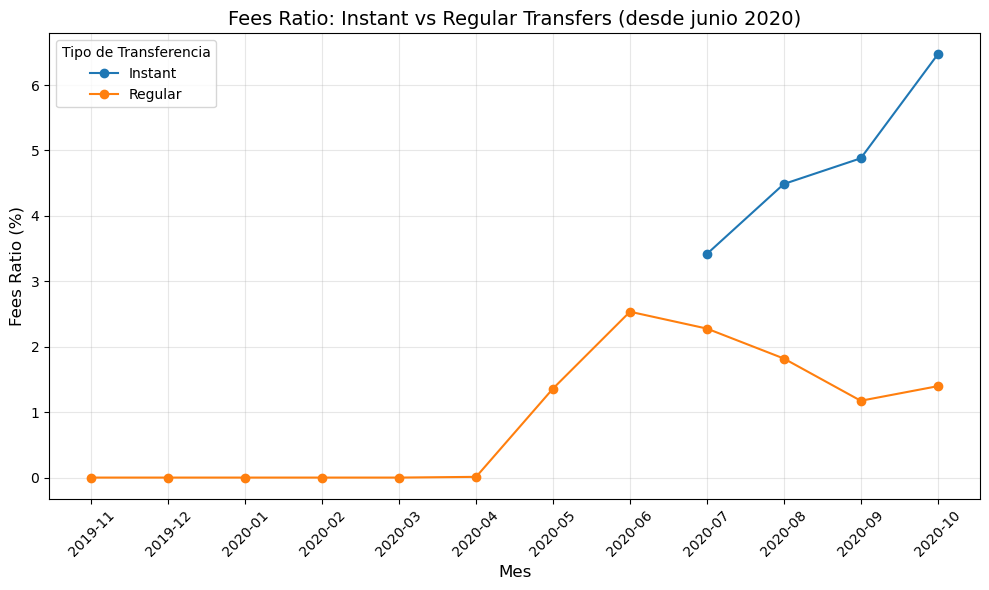

In [6]:
# Pivotar los datos para facilitar la gráfica
pivot_data = monthly_data.pivot(index='Mes_created_at', columns='transfer_type', values='fees_ratio')

# Asegurarse de que el índice sea un string para graficar
pivot_data.index = pivot_data.index.astype(str)

# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(pivot_data.index, pivot_data['instant'], label='Instant', marker='o')
plt.plot(pivot_data.index, pivot_data['regular'], label='Regular', marker='o')

# Personalizar la gráfica
plt.title('Fees Ratio: Instant vs Regular Transfers (desde junio 2020)', fontsize=14)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Fees Ratio (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Tipo de Transferencia')
plt.grid(alpha=0.3)

# Mostrar la gráfica
plt.tight_layout()
plt.show()



In [7]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
df_jo['Cohorte'] = df_jo.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
df_jo.head(10)

,id_cr,amount,stat_cr,created_at,user_id,active,moderated_at,reimbursement_date,cash_request_received_date,money_back_date,...,stat_fe,category,fee,paid_at,from_date,to_date,charge_moment,cr_received_date,to_reimbur_cash_de,Cohorte
0,5,100.0,rejected,2019-12-10 19:05:21.596873,804,1,2019-12-11 16:47:42.405646,2020-01-09 19:05:21.596363,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780,231,1,2019-12-11 14:24:22.897988,2020-01-09 19:50:12.347780,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460,191,1,2019-12-11 09:46:59.777728,2020-01-09 19:13:35.825041,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172,761,1,2019-12-18 14:26:18.128407,2020-01-09 19:16:10.879606,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,7686,1,2020-05-07 09:21:55.320193,2020-06-05 22:00:00.000000,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2020-05
5,2145,100.0,money_back,2020-05-23 20:58:55.129432,9489,1,2020-05-24 12:40:33.054910,2020-06-06 22:00:00.000000,2020-05-26,2020-07-06 03:36:03.023521,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2020-05-26,NaN,2020-05
6,3512,100.0,rejected,2020-06-16 17:07:38.452652,14631,1,2020-06-17 10:21:21.360742,2020-07-11 23:51:00.000000,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2020-06
7,654,100.0,rejected,2020-02-10 01:11:53.808270,99000309,0,2020-02-10 09:11:21.350695,2020-03-11 01:11:53.807930,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2020-01
8,5672,100.0,canceled,2020-06-28 12:06:33.712840,99002499,0,NaT,2020-07-07 22:00:00.000000,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2020-06
9,71,90.0,rejected,2019-12-10 19:51:23.911206,897,1,2019-12-12 15:06:11.190299,2019-12-17 19:51:23.910748,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2019-12


In [8]:
# Agrupar los datos por cohorte y mes para calcular las métricas mensuales
cohort_analysis = df_jo.groupby(['Cohorte', 'Mes_created_at']).agg(
    Num_Clientes=('user_id', 'nunique'),  # Número de clientes únicos por cohorte y mes
    Num_Solicitudes=('id_cr', 'nunique'),  # Total de solicitudes únicas por cohorte y mes
    Solicitudes_Instant=('transfer_type', lambda x: (x == 'instant').sum()),  # Solicitudes tipo 'instant' por cohorte y mes
    Solicitudes_Regular=('transfer_type', lambda x: (x == 'regular').sum()),  # Solicitudes tipo 'regular' por cohorte y mes
    Clientes_con_fees=('fee', lambda x: (x > 0).sum()),  # Clientes con fees por cohorte y mes
    CR=('id_cr', lambda ids: df_jo.loc[ids.index].drop_duplicates(subset='id_cr')['amount'].sum()),  # Total de adelantos únicos
    Fees=('fee', 'sum'),  # Total de fees por cohorte y mes
    # Contar las líneas con 'stat_fe' == 'accepted'
    paid_fees=('stat_fe', lambda x: (x == 'accepted').sum()),  
    # Contar las líneas con 'stat_fe' != 'accepted'
    non_paid_fees=('stat_fe', lambda x: (x != 'accepted').sum()),
    # Sumar 'total_amount' cuando 'stat_fe' == 'accepted'
    total_paid_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),
    # Sumar 'total_amount' cuando 'stat_fe' != 'accepted'
    total_non_paid_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] != 'accepted'].sum()),
     # Contar las líneas con 'stat_cr' == 'money_back'
    paid_cr=('stat_cr', lambda x: (x == 'money_back').sum()),  
    # Contar las líneas con 'stat_fe' != 'accepted'
    non_paid_cr=('stat_cr', lambda x: (x != 'money_back').sum()),
    # Sumar 'total_amount' cuando 'stat_fe' == 'accepted'
    total_paid_cr=('amount', lambda x: x[df_jo.loc[x.index, 'stat_cr'] == 'money_back'].sum()),
    # Sumar 'total_amount' cuando 'stat_fe' != 'accepted'
    total_non_paid_cr=('amount', lambda x: x[df_jo.loc[x.index, 'stat_cr'] != 'money_back'].sum()),
    # Métrica de "credit lapse" (diferencia entre reimbursement_date y created_at)
    credit_lapse=('reimbursement_date', lambda x: (x - df_jo.loc[x.index, 'created_at']).dt.days.mean()),
    # Métrica de "credit payment lapse" (diferencia entre money_back_date y reimbursement_date)
    credit_payment_lapse=('money_back_date', lambda x: (x - df_jo.loc[x.index, 'reimbursement_date']).dt.days.mean())

).reset_index()

# Calcular los porcentajes de non_paid_fees
cohort_analysis['paid_fees_percent_qty'] = (cohort_analysis['paid_fees'] / (cohort_analysis['paid_fees'] + cohort_analysis['non_paid_fees']))
cohort_analysis['paid_fees_percent_amount'] = (cohort_analysis['total_paid_fees'] / cohort_analysis['Fees'])   # % en monto
cohort_analysis['paid_cr_percent_qty'] = (cohort_analysis['paid_cr'] / (cohort_analysis['paid_cr'] + cohort_analysis['non_paid_cr']))
cohort_analysis['paid_cr_percent_amount'] = (cohort_analysis['total_paid_cr'] / cohort_analysis['CR'])   # % en monto
cohort_analysis['index'] = (cohort_analysis['total_paid_fees'] / cohort_analysis['total_paid_cr'])   # % index

# Eliminar las columnas de pago y no pago
cohort_sizes_monthly = cohort_analysis.drop(
    ['paid_fees', 'non_paid_fees', 'total_paid_fees', 'total_non_paid_fees','paid_cr', 'non_paid_cr', 'total_paid_cr', 'total_non_paid_cr'], axis=1, errors='ignore')

# Mostrar los resultados de las cohortes por mes
cohort_analysis


,Cohorte,Mes_created_at,Num_Clientes,Num_Solicitudes,Solicitudes_Instant,Solicitudes_Regular,Clientes_con_fees,CR,Fees,paid_fees,...,non_paid_cr,total_paid_cr,total_non_paid_cr,credit_lapse,credit_payment_lapse,paid_fees_percent_qty,paid_fees_percent_amount,paid_cr_percent_qty,paid_cr_percent_amount,index
0,2019-11,2019-11,1,1,0,1,0,1.0,0.0,0,...,1,0.0,1.0,16.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
1,2019-11,2019-12,1,1,0,1,0,100.0,0.0,0,...,1,0.0,100.0,6.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
2,2019-11,2020-04,1,1,0,1,0,100.0,0.0,0,...,0,100.0,0.0,14.000000,8.000000,0.000000,NaN,1.000000,1.000000,0.000000
3,2019-11,2020-05,1,1,0,5,5,10.0,25.0,1,...,0,50.0,0.0,125.000000,-45.000000,0.200000,0.200000,1.000000,5.000000,0.100000
4,2019-11,2020-08,1,1,2,0,2,10.0,10.0,2,...,0,20.0,0.0,55.000000,-8.000000,1.000000,1.000000,1.000000,2.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2020-08,2020-09,291,342,433,59,351,24670.0,1755.0,253,...,179,23710.0,11810.0,34.894309,7.150150,0.514228,0.720798,0.636179,0.961086,0.053353
69,2020-08,2020-10,245,279,310,29,283,21930.0,1415.0,230,...,43,23430.0,3280.0,24.241888,4.027027,0.678466,0.812721,0.873156,1.068399,0.049082
70,2020-09,2020-09,1988,2220,3157,204,2378,168602.0,11890.0,1642,...,1186,178508.0,85449.0,31.353764,9.304796,0.488545,0.690496,0.647129,1.058754,0.045992
71,2020-09,2020-10,679,727,866,70,845,49865.0,4225.0,634,...,117,57935.0,7585.0,24.603632,4.123040,0.677350,0.750296,0.875000,1.161837,0.054716


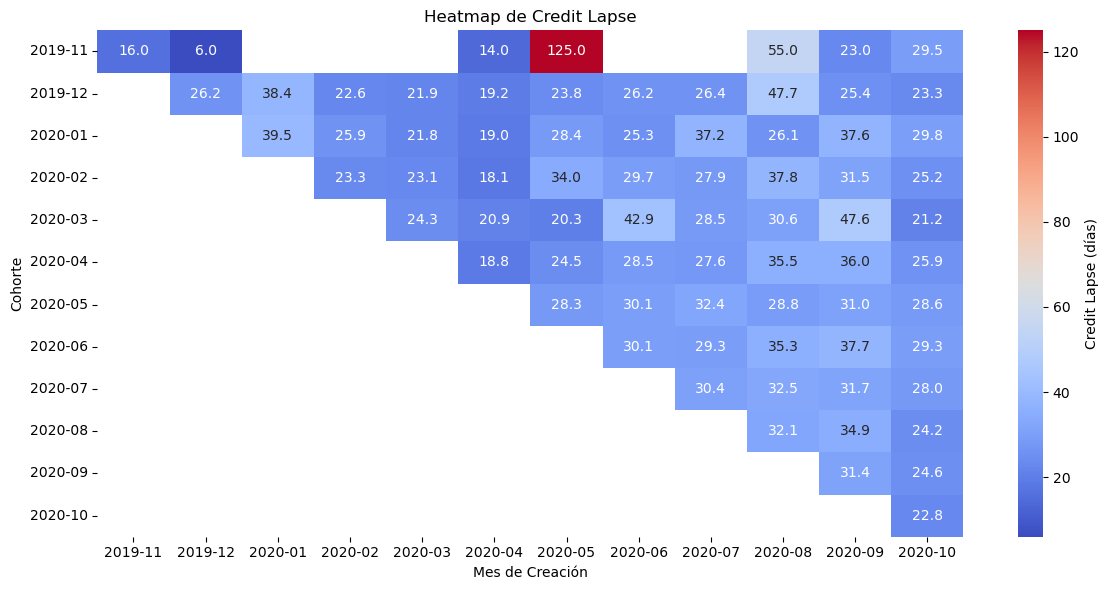

In [9]:
# Crear los datos para el heatmap
heatmap_data = cohort_analysis.pivot(
    index='Cohorte', 
    columns='Mes_created_at', 
    values='credit_lapse'
)

# Crear la figura para el heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".1f", 
    cmap="coolwarm", 
    cbar_kws={'label': 'Credit Lapse (días)'}
)

# Personalizar el heatmap
plt.title('Heatmap de Credit Lapse')
plt.xlabel('Mes de Creación')
plt.ylabel('Cohorte')
plt.tight_layout()
plt.show()


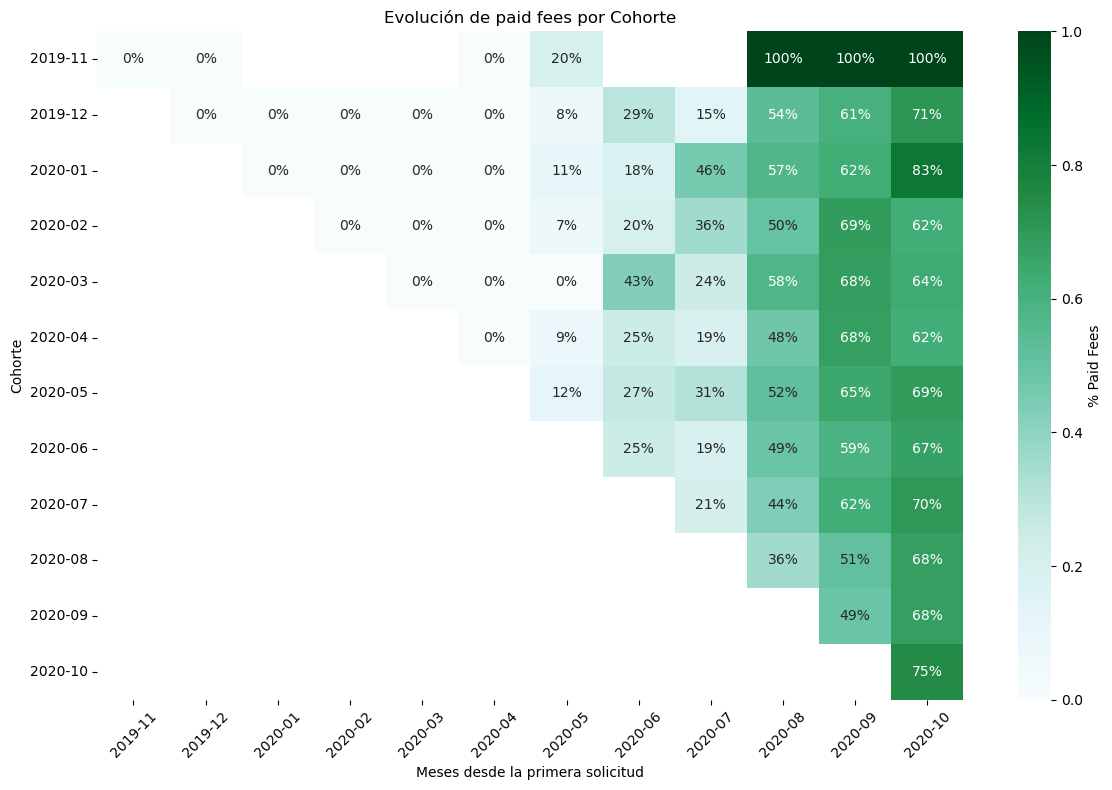

In [10]:
# Pivotar los datos para crear una matriz de fees pagados por cohorte para cada mes
paid_fees_heatmap_data = cohort_analysis.pivot(index='Cohorte', columns='Mes_created_at', values='paid_fees_percent_qty')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(paid_fees_heatmap_data, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='BuGn', cbar_kws={'label': '% Paid Fees'})

# Añadir etiquetas y título
plt.title('Evolución de paid fees por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Mostrar el heatmap
plt.tight_layout()
plt.show()


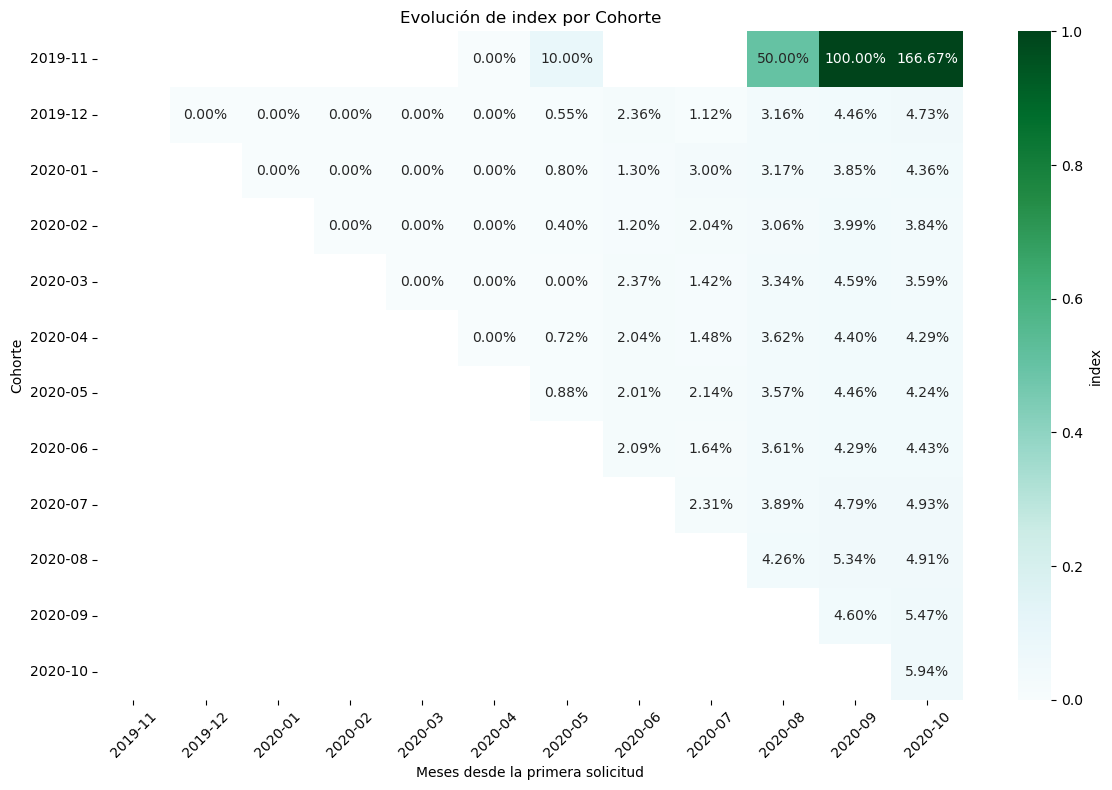

In [11]:
# Pivotar los datos para crear una matriz de index por cohorte para cada mes
paid_fees_heatmap_data = cohort_analysis.pivot(index='Cohorte', columns='Mes_created_at', values='index')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(paid_fees_heatmap_data, annot=True, fmt='.2%', vmin=0.0, vmax=1.0, cmap='BuGn', cbar_kws={'label': 'index'})

# Añadir etiquetas y título
plt.title('Evolución de index por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Mostrar el heatmap
plt.tight_layout()
plt.show()


In [12]:
cohort_analysis_2 = (
    df_jo.groupby(['user_id', 'Mes_created_at'], as_index=False)
    .agg(
        # Sum 'fee' where 'stat_fe' == 'accepted'
        total_paid_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),
        
        # Sum 'amount' where 'stat_cr' == 'money_back'
        total_paid_cr=('amount', lambda x: x[df_jo.loc[x.index, 'stat_cr'] == 'money_back'].sum()),

        # Calculate the mean of 'to_reimbur_cash'
        reimburse_lapse=('to_reimbur_cash', 'mean')
)
)

# Reset index for clean DataFrame (optional, already ensured by as_index=False)
cohort_analysis_2.reset_index(drop=True, inplace=True)

# Calculate the index metric
cohort_analysis_2['index'] = (
    cohort_analysis_2['total_paid_fees'] / cohort_analysis_2['total_paid_cr']
)

# Replace 'inf' values with 0
cohort_analysis_2['index'] = cohort_analysis_2['index'].replace(np.inf, 0)

cohort_analysis_2['last_order']=['created_at'].transform('max').dt.to_period('M')

cohort_analysis_2


AttributeError: 'list' object has no attribute 'transform'

In [ ]:
# Ordenar por el monto total para encontrar los 10 usuarios principales
# Filter rows where total_paid_cr is greater than 100
cohort_analysis_2_filtered = cohort_analysis_2[cohort_analysis_2['total_paid_cr'] ==100]
sort_cohort_amount_2020_03 = cohort_analysis_2_filtered.sort_values(by=['index','reimburse_lapse'], ascending=[False, True])
top_10_users = sort_cohort_amount_2020_03.head(20)
top_10_users

In [ ]:
# Pivot the data to create a matrix of paid_cr per cohort for each month
paid_cr_heatmap_data = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes_created_at', values='paid_cr_percent_qty')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(paid_cr_heatmap_data, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='BuGn', cbar_kws={'label': '% Paid CR'})

# Add labels and title
plt.title('Evolución de paid CR por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Show the heatmap
plt.tight_layout()
plt.show()

In [ ]:
cohort_ltv_monthly = cohort_analysis.groupby(['Cohorte', 'Mes_created_at']).agg(
    Total_Fees=('Fees', 'sum'),  
    Clientes=('Num_Clientes', 'sum') 
).reset_index()


# Calcular el LTV mensual
cohort_ltv_monthly['LTV_Mensual'] = cohort_ltv_monthly['Total_Fees'] / cohort_ltv_monthly['Clientes']
cohort_ltv_monthly

In [ ]:
# Reorganizar los datos en una matriz para el heatmap
ltv_matrix = cohort_ltv_monthly.pivot(index='Cohorte', columns='Mes_created_at', values='LTV_Mensual')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=ltv_matrix, annot=True, fmt='.2f', cmap='BuGn', cbar_kws={'label': 'LTV Promedio Mensual'})
plt.title('Evolución Mensual del LTV por Cohorte')
plt.xlabel('Mes de Actividad')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Ordenar por el monto total para encontrar los 10 usuarios principales
sort_cohort_amount_2020_06 = cohort_amount_2020_06_top10.sort_values(by='amount', ascending=False)
top_10_users = sort_cohort_amount_2020_06.head(10)
top_10_users

In [ ]:
# Filter for Cohorte '2020-06' and calculate unique id_cr sums per user and month
amount_2020_06 = (
    df_jo[
        (df_jo['Cohorte'] == '2020-06') &  # Filter cohort
        (df_jo['cash_request_received_date'].notna())  # Ensure cash_request_received_date is not null
    ]
    .drop_duplicates(subset=['user_id', 'Mes_created_at', 'id_cr'])  # Remove duplicate id_cr
    .groupby(['user_id', 'Mes_created_at'])['amount']
    .sum()
    .reset_index()
)


# Filter for the top 10 users
cohort_amount_2020_06_top10 = amount_2020_06[amount_2020_06['user_id'].isin(top_10_users['user_id'])]

# Pivot to show months as columns
cohort_amount_2020_06_top10 = cohort_amount_2020_06_top10.pivot(index='user_id', columns='Mes_created_at', values='amount')

# Display the result
cohort_amount_2020_06_top10


In [ ]:
# Graficar la cantidad de adelanto de efectivo de un cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-06 por Meses por Año y Número de Usuario')
sns.heatmap(data=cohort_amount_2020_06_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()

In [ ]:
# Agregar columnas de temporalidad
# Semana y mes de la solicitud
df_jo['Semana_Mes'] = df_jo['created_at'].dt.strftime('%U_%B') + '_' + df_jo['Mes_created_at'].dt.strftime('%Y')
# Día y semana de la solicitud
df_jo['Dia_Semana'] = df_jo['created_at'].dt.strftime('%A') + '_' + df_jo['Semana_Mes']
# Hora y dia de la solicitud
df_jo['Hora_Dia'] = df_jo['created_at'].dt.hour.astype(str) + '_' + df_jo['Dia_Semana']
df_jo.head()

In [ ]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y semana
cohort_weekly_amount = df_jo[df_jo['Cohorte'] == '2020-06'].groupby(['user_id','Semana_Mes'])['amount'].sum().reset_index()
cohort_weekly_amount

In [ ]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_weekly_amount_top10 = cohort_weekly_amount[cohort_weekly_amount['user_id'].isin(top_10_users['user_id'])]
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.pivot(index='user_id', columns='Semana_Mes', values='amount')
cohort_weekly_amount_top10

In [ ]:
# Seleccionar las primeras 10 semanas
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.loc[:,cohort_weekly_amount_top10.columns[9:19]]
cohort_weekly_amount_top10

In [ ]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-06 por Semana por Mes y Número de Usuario')
sns.heatmap(data=cohort_weekly_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Semana por Mes')
plt.ylabel('Número de Usuario')
plt.show()


In [ ]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y día de la semana
cohort_daily_amount = df_jo[ (df_jo['Cohorte'] == '2020-06') & (df_jo['Semana_Mes'] == '32_August_2020') ].groupby(['user_id', 'Dia_Semana'])['amount'].sum().reset_index()
cohort_daily_amount

In [ ]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_daily_amount_top10 = cohort_daily_amount[cohort_daily_amount['user_id'].isin(top_10_users['user_id'])]
cohort_daily_amount_top10 = cohort_daily_amount_top10.pivot(index='user_id',columns='Dia_Semana', values='amount')
cohort_daily_amount_top10

In [ ]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por día de la semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Día por Semana y Número de Usuario')
sns.heatmap(data=cohort_daily_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Día por Semana')
plt.ylabel('Número de Usuario')
plt.show()


In [ ]:
# Calcular el tamaño inicial de las cohortes (primer mes de cada cohorte)
cohort_ltv_monthly['Clientes_Iniciales'] = cohort_ltv_monthly.groupby('Cohorte')['Clientes'].transform('first')

# Calcular las tasas de retención
cohort_ltv_monthly['Retention_Rate'] = cohort_ltv_monthly['Clientes'] / cohort_ltv_monthly['Clientes_Iniciales']

# Crear una matriz de retención
retention_matrix = cohort_ltv_monthly.pivot(index='Cohorte', columns='Mes_created_at', values='Retention_Rate')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    retention_matrix, 
    annot=True, 
    fmt='.0%', 
    cmap='coolwarm', 
    cbar_kws={'label': 'Retention Rate'}
)
plt.title('Tasas de Retención de Cohortes a lo Largo del Tiempo')
plt.xlabel('Meses desde la Primera Solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


